Regression - Optimize and save models

In [24]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
bike_data = pd.read_csv('daily-bike-share.csv')
bike_data['day'] = pd.DatetimeIndex(bike_data['dteday']).day
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit', 'day']
bike_data[numeric_features + ['rentals']].describe()
print(bike_data.head())

   instant    dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  1/1/2011       1   0     1        0        6           0   
1        2  1/2/2011       1   0     1        0        0           0   
2        3  1/3/2011       1   0     1        0        1           1   
3        4  1/4/2011       1   0     1        0        2           1   
4        5  1/5/2011       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  rentals  day  
0           2  0.344167  0.363625  0.805833   0.160446      331    1  
1           2  0.363478  0.353739  0.696087   0.248539      131    2  
2           1  0.196364  0.189405  0.437273   0.248309      120    3  
3           1  0.200000  0.212122  0.590435   0.160296      108    4  
4           1  0.226957  0.229270  0.436957   0.186900       82    5  


In [17]:
# Separate features and labels
# After separating the dataset, we now have numpy arrays named **X** containing the features, and **y** containing the labels.
X, y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 511 rows
Test Set: 220 rows


Gradient Boosting estimator, is like a Random Forest algorithm, but instead of building them all trees independently and taking the average result, each tree is built on the outputs of the previous one in an attempt to incrementally reduce the loss (error) in the model.

Model Trained!
MSE:  103842.04852892879
RMSE:  322.2453235175474
R2:  0.7964241813642632


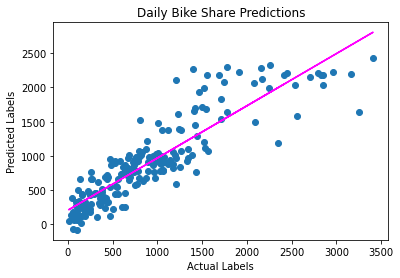

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor().fit(X_train, y_train)
print('Model Trained!')

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print('MSE: ', mse)
rmse = np.sqrt(mse)
print('RMSE: ', rmse)
r2 = r2_score(y_test, predictions)
print('R2: ', r2)

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')

z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()

Optimize Hyperparameters

Let's try using a grid search approach to try combinations from a grid of possible values for the learning_rate and n_estimators hyperparameters of the GradientBoostingRegressor estimator.

Best parameter combination: {'learning_rate': 0.1, 'n_estimators': 50} 

GradientBoostingRegressor(n_estimators=50) 

MSE: 108738.48090544103
RMSE: 329.7551832882101
R2: 0.786825033008043


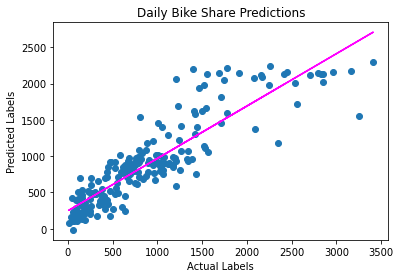

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Try these hyperparameter values
params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
 }

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
model=gridsearch.best_estimator_
print(model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [20]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [6,7,8,9]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = [0,1,2,3,4,5]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('regressor', GradientBoostingRegressor())])


OK, the model is trained, including the preprocessing steps. Let's see how it performs with the validation data.

MSE: 105069.28171929331
RMSE: 324.14392130548015
R2: 0.7940182677201789


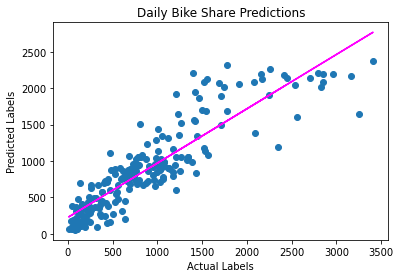

In [21]:
# Get predictions
predictions = model.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('regressor', RandomForestRegressor())]) 

MSE: 108530.83152954545
RMSE: 329.44017898481275
R2: 0.787232116576655


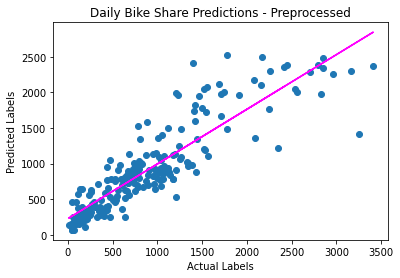

In [25]:
# Use a different estimator in the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model, "\n")

# Get predictions
predictions = model.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions - Preprocessed')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

Use the Trained Model

In [26]:
import joblib

# Save the model as a pickle file
filename = './bike-share.pkl'
joblib.dump(model, filename)

['./bike-share.pkl']

Now, we can load it whenever we need it, and use it to predict labels for new data. This is often called scoring or inferencing.

In [27]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[1,1,0,3,1,1,0.226957,0.22927,0.436957,0.1869]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} rentals'.format(np.round(result[0])))

New sample: [1.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.226957, 0.22927, 0.436957, 0.1869]
Prediction: 100 rentals


The model's predict method accepts an array of observations, so you can use it to generate multiple predictions as a batch. For example, suppose you have a weather forecast for the next five days; you could use the model to predict bike rentals for each day based on the expected weather conditions.

In [29]:
# An array of features based on five-day weather forecast
X_new = np.array([[0,1,1,0,0,1,0.344167,0.363625,0.805833,0.160446],
                  [0,1,0,1,0,1,0.363478,0.353739,0.696087,0.248539],
                  [0,1,0,2,0,1,0.196364,0.189405,0.437273,0.248309],
                  [0,1,0,3,0,1,0.2,0.212122,0.590435,0.160296],
                  [0,1,0,4,0,1,0.226957,0.22927,0.436957,0.1869]])

# Use the model to predict rentals
results = loaded_model.predict(X_new)
print('5-day rental predictions:')
for prediction in results:
    print(np.round(prediction))

5-day rental predictions:
604.0
678.0
247.0
193.0
280.0
